In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Installation & Importing

## Installing packages

In [ ]:
!nvidia-smi
import os
HOME = os.getcwd()
print("HOME:", HOME)
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

Wed Sep 18 18:52:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Optionally, move files from Google Drive to your desired directory in Colab
import shutil
shutil.copy("/content/PMNS-574.JPG", f"{HOME}/data/PMNS-574.JPG")

'/content/data/PMNS-574.JPG'

In [ ]:
!pip install POT
!pip install opencv-python
!pip install gudhi
!pip install scipy
!pip install GPyOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 25.8 MB/s eta 0:00:00


## Importing Libraries

In [ ]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity
from sklearn.preprocessing import MinMaxScaler
from GPyOpt.methods import BayesianOptimization
import ot
import matplotlib.pyplot as plt
import skimage
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from skimage.draw import circle_perimeter
from skimage.filters import threshold_otsu
from PIL import Image
from scipy.ndimage import convolve
from skimage.util import invert
from skimage.feature import corner_harris, corner_peaks
from scipy.spatial import distance_matrix
import gudhi as gd
from sklearn.cluster import KMeans
import os
import itertools
from scipy.stats import wasserstein_distance
import pandas as pd
import seaborn as sns

In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv

# SAM

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(model=sam,
                                          )

In [ ]:
IMAGE_NAME = "PMNS-574.JPG"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

## Generating Masks

In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)

resized_image_bgr = cv2.resize(image_bgr,(image_bgr.shape[1] // 2,image_bgr.shape[0] // 2))

image_rgb = cv2.cvtColor(resized_image_bgr, cv2.COLOR_BGR2RGB)

torch.cuda.empty_cache()

sam_result = mask_generator.generate(image_rgb)
print(sam_result[0].keys())

##Visualization with Supervision

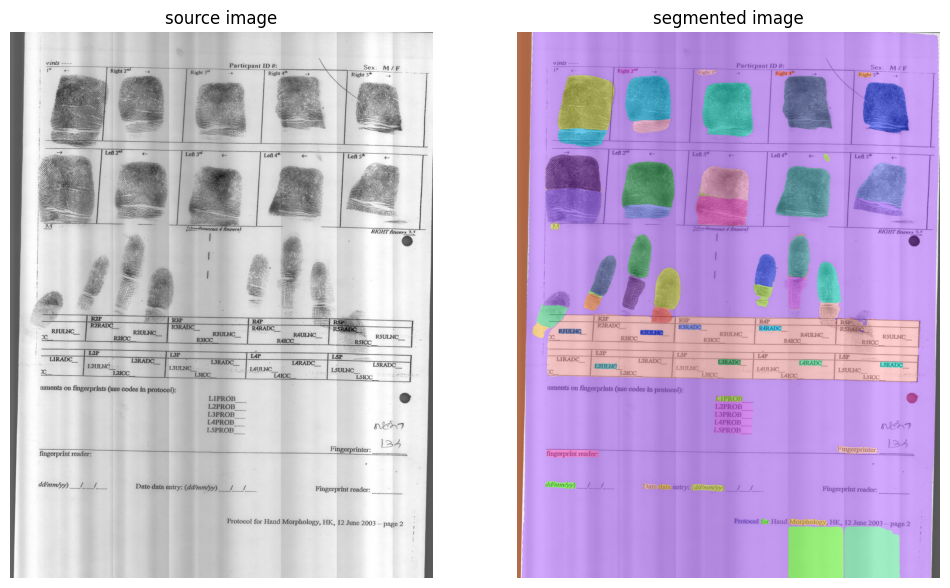

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=resized_image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[resized_image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

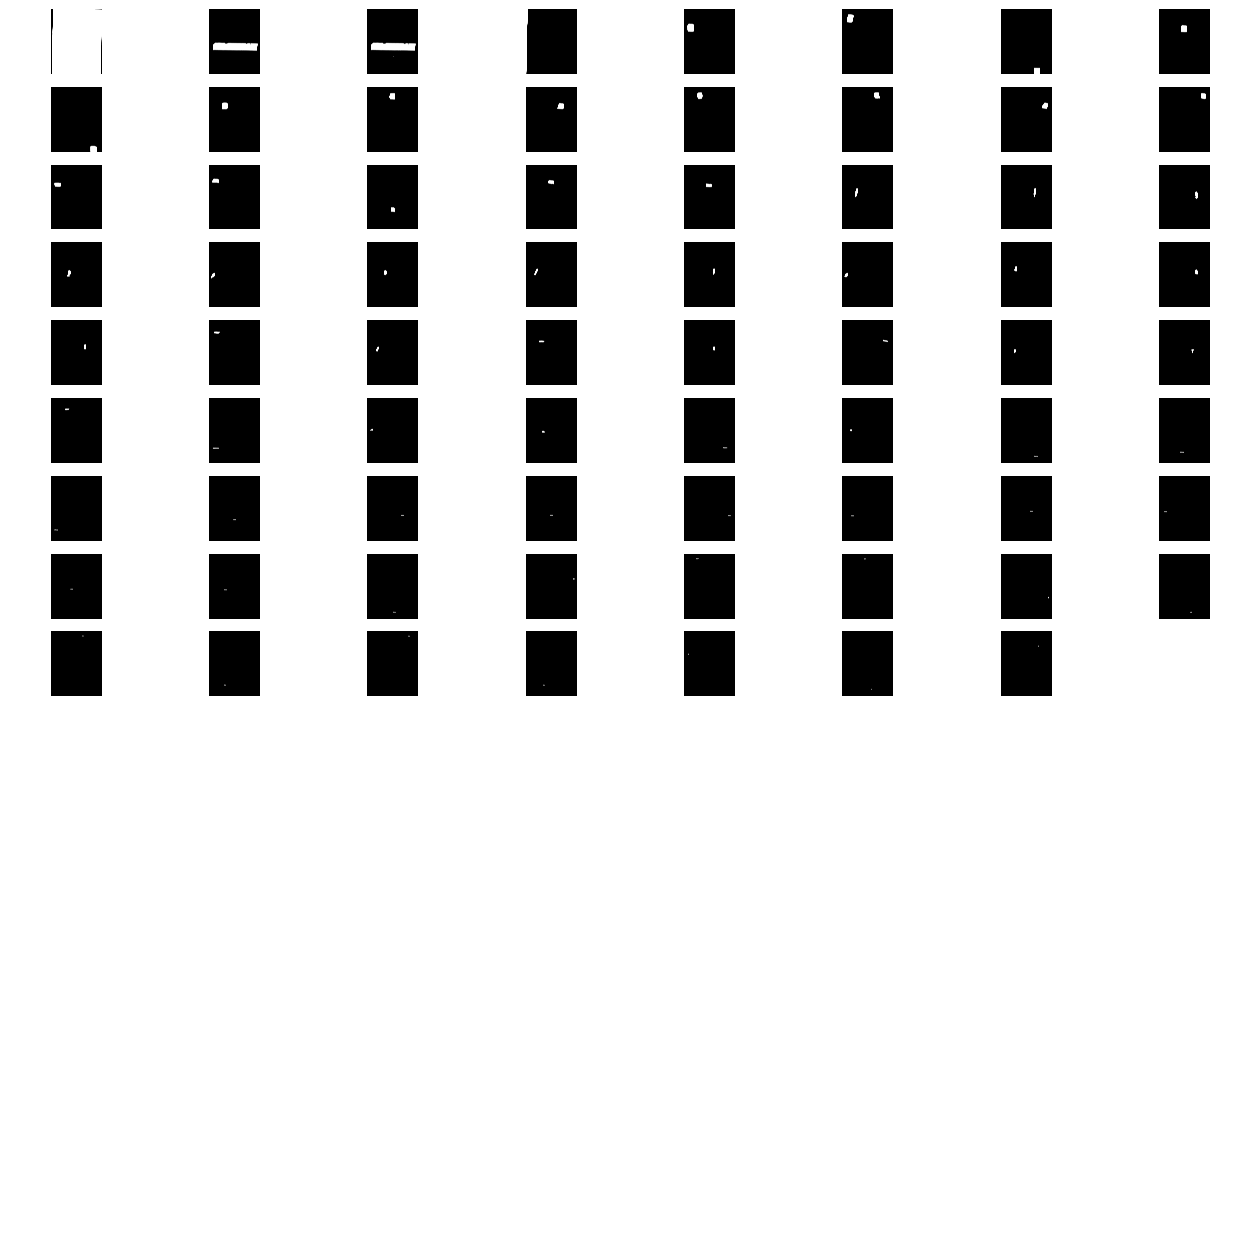

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(16, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

In [ ]:
mask_predictor = SamPredictor(sam)
import os
from jupyter_bbox_widget import BBoxWidget
from google.colab import output

resized_image_path = "/content/resized_image.jpg"
cv2.imwrite(resized_image_path, image_rgb)

# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

IS_COLAB = True
if IS_COLAB:
  output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(resized_image_path)
widget
widget.bboxes

##Generate masks with SAM

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(resized_image_path)
image_rgb = cv2.cvtColor(resized_image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

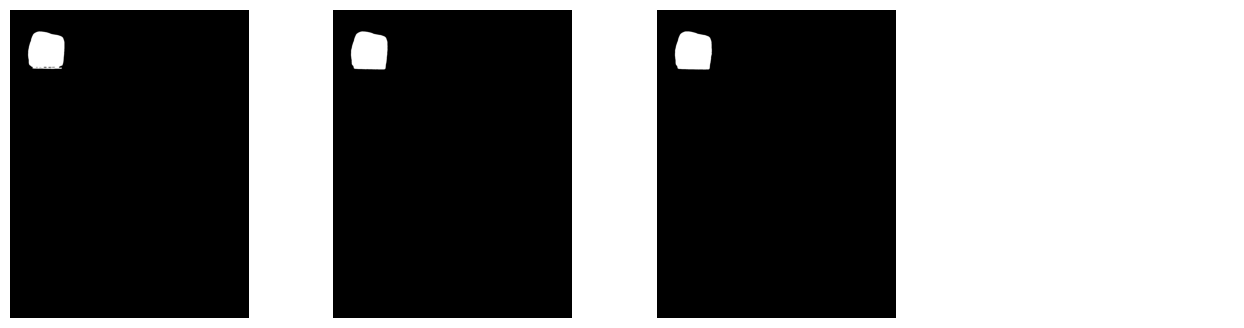

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

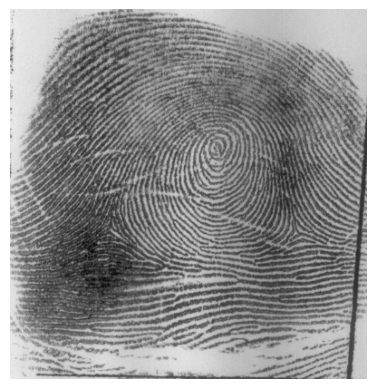

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select the largest mask (assuming the largest mask is the target segment)
segmentation_mask = masks[2]

# Convert the mask to a binary mask
binary_mask = np.where(segmentation_mask > 0.5, 1, 0).astype(np.uint8)

# Find contours to get the bounding box of the segmented area
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])

# Crop the image using the bounding box
cropped_image = image_bgr[y:y+h, x:x+w]
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
cropped_image_rgb

# Sementic Sketching

## Sketching

# Image preprocessing
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(blur)

    return equalized


# Helper function to compute Sinkhorn distance
def sinkhorn_distance(hist1, hist2, epsilon=0.1):
    M = ot.dist(hist1.reshape(-1, 1), hist2.reshape(-1, 1), metric='euclidean')
    return ot.sinkhorn2(hist1, hist2, M, reg=epsilon)

import itertools

# Objective function for Bayesian optimization
def objective_function(params):
    # Unpack hyperparameters
    sigma = params[0][0]
    alpha = params[0][1]
    beta = params[0][2]


    # Apply semantic sketching
    sketched = apply_semantic_sketching(fingerprint, sigma, alpha, beta)

# Compute Sinkhorn distance

    # Compute histogram of edge intensities
    hist, _ = np.histogram(fingerprint, bins=256, range=(0, 256), density=True)

    # Reference histogram (e.g., uniform distribution)
    ref_hist, _ = np.histogram(sketched, bins=256, range=(0, 256), density=True)

    distance = sinkhorn_distance(hist, ref_hist)
    return -distance


# Semantic sketching function
def apply_semantic_sketching(image, sigma, alpha, beta):
    # Apply Gaussian smoothing
    smoothed = cv2.GaussianBlur(image, (0, 0), sigma)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, alpha)

    # Apply dilation and erosion
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    # Adjust intensity
    adjusted = cv2.addWeighted(eroded, beta, image, 1 - beta, 0)

    return adjusted

In [ ]:
image_path = '/content/fingerprint_609_1.png'
#image_path = '/content/1000.jpg'
image = cv2.imread(image_path)

In [ ]:
# Preprocess input image
fingerprint = preprocess_image(image)

# Apply semantic sketching with default hyperparameters
default_sigma = 2.0
default_alpha = 4.0
default_beta = 0.5
target_sketch = apply_semantic_sketching(fingerprint, default_sigma, default_alpha, default_beta)

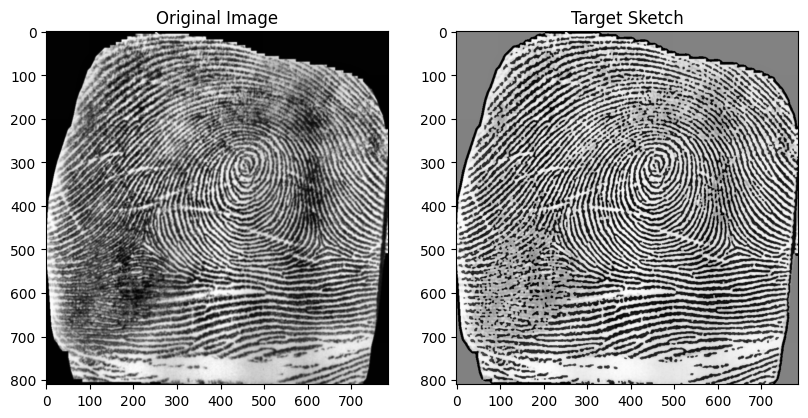

In [ ]:
import matplotlib.pyplot as plt
# Display the images for visual inspection
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(fingerprint, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Target Sketch')
plt.imshow(target_sketch, cmap='gray')

plt.show()

In [ ]:

# Compute histogram of edge intensities
hist, _ = np.histogram(fingerprint, bins=256, range=(0, 256), density=True)

# Reference histogram (e.g., uniform distribution)
ref_hist, _ = np.histogram(target_sketch, bins=256, range=(0, 256), density=True)


sinkhorn_value = sinkhorn_distance(hist, ref_hist)
print(f"Sinkhorn distance between target sketch and sketched image: {sinkhorn_value:.4f}")

Sinkhorn distance between target sketch and sketched image: 0.0036


## Baysiean Optimization

In [ ]:
# Define hyperparameter bounds
bounds = [{'name': 'sigma', 'type': 'continuous', 'domain': (0.1, 2)},
          {'name': 'alpha', 'type': 'continuous', 'domain': (0.1, 2)},
          {'name': 'beta', 'type': 'continuous', 'domain': (0.1, 2)}]

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=objective_function, domain=bounds, maximize=False)

0.21384428711049142 1.5149836238783925 1.6703383489540633
0.003589365053838457
1.1783289894940996 1.9281824884410672 1.6477754281896004
0.003588073129964674
1.923222864049364 1.4389371250997431 0.7549300939455749
0.004722294204349325
0.17190872967966925 1.9045014992833247 1.9240375971469967
0.003589365053838457
0.5654203639030185 0.36077710838308363 1.4625941367911013
0.003586003203344017


In [ ]:
optimizer.run_optimization(max_iter=100)

# Get optimal hyperparameters
optimal_params = optimizer.x_opt

# Apply semantic sketching with optimal hyperparameters
sketched = apply_semantic_sketching(fingerprint, *optimal_params)

# Save the sketched image
cv2.imwrite('sketched_fingerprint.png', sketched)

2.0 1.3631720168531227 0.3746195145178937
0.0027833963486431916
0.7391280576951743 1.3546751401894057 1.9154694819645979
0.003588447447435089
0.6743841175121107 1.5707382075363032 0.8156415182577358
0.0051276225096249595
1.30674191785654 0.39364951872828746 1.3155525909017862
0.0035850501790202615
0.6554993104152563 1.5878648433505125 0.7947498296620435
0.004941801253163677
0.71579389141973 1.5293867670054895 0.8139280130227922
0.005052899060690051
0.6861613628821557 1.564554685629444 0.8848066741844886
0.005368460595226369
0.7433583055892855 1.6359089511597127 0.9094600990722004
0.005410553075133314
0.693859289174477 1.6014616922226166 1.0210821285228038
0.003588505358116074
0.7365380268430951 1.6114266631489094 0.865860252780625
0.005306374323428984
0.7260350971840227 1.6935982547139672 0.8855776243722587
0.005370651106084599
0.809335869889055 1.69086108173204 0.8977220447517213
0.005399129562889917
0.8079593844400298 1.8158913840660806 0.9025776336181323
0.005404507588798331
0.92765

True

In [ ]:
print(optimal_params)

[1.23550456 1.68482114 0.91469629]


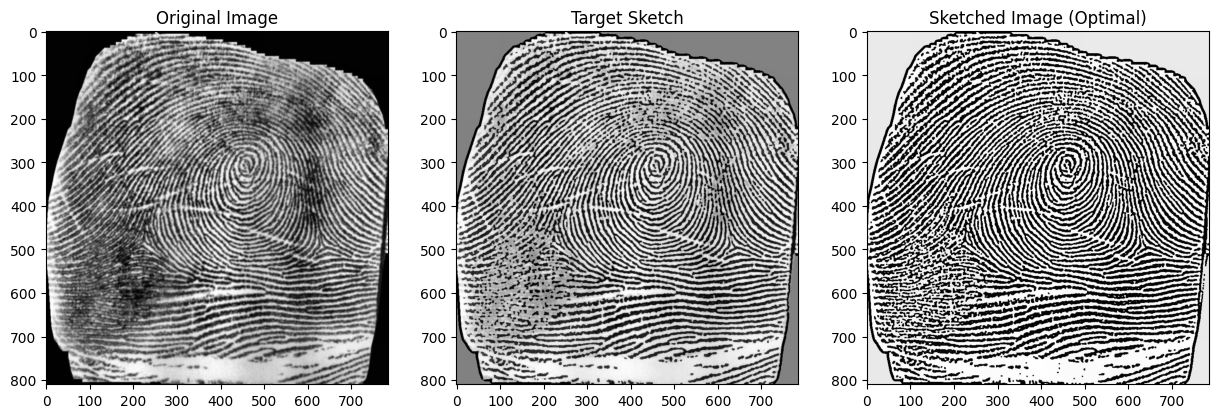

In [ ]:
from skimage.metrics import structural_similarity as ssim
# Display the images for visual inspection
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(fingerprint, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Target Sketch')
plt.imshow(target_sketch, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Sketched Image (Optimal)')
plt.imshow(sketched, cmap='gray')

plt.show()

In [ ]:
# Quantitative comparison using SSIM
ssim_value = ssim(fingerprint, sketched)
print(f"SSIM between input image and sketched image: {ssim_value:.4f}")

# Compute histogram of edge intensities
hist, _ = np.histogram(fingerprint, bins=256, range=(0, 256), density=True)

# Reference histogram (e.g., uniform distribution)
ref_hist, _ = np.histogram(sketched, bins=256, range=(0, 256), density=True)


# Quantitative comparison using Sinkhorn distance
sinkhorn_value = sinkhorn_distance(hist,ref_hist)
print(f"Sinkhorn distance between input image and sketched image: {sinkhorn_value:.4f}")

SSIM between input image and sketched image: 0.4530
Sinkhorn distance between input image and sketched image: 0.0055


array([[234, 234, 234, ..., 234, 234, 234],
       [234, 234, 234, ..., 234, 234, 234],
       [234, 234, 234, ..., 234, 234, 234],
       ...,
       [233, 233, 233, ..., 234, 234, 234],
       [233, 233, 233, ..., 234, 234, 234],
       [233, 233, 233, ..., 234, 234, 234]], dtype=uint8)
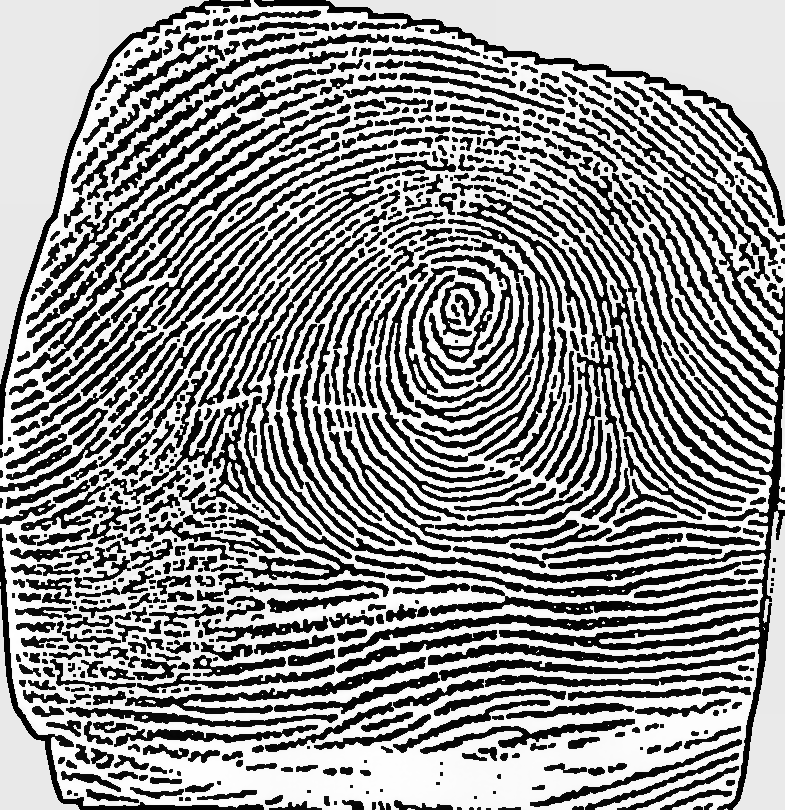

In [ ]:
sketched

# Minutiae Points

In [ ]:
plt.rcParams['text.usetex'] = False
# Function to detect ridges using Hessian matrix
def detect_ridges(gray, sigma=0.1):
    H_elems = skimage.feature.hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = skimage.feature.hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

# Function to get termination and bifurcation points
def getTerminationBifurcation(img, mask):
    img = img == 255
    (rows, cols) = img.shape
    minutiaeTerm = np.zeros(img.shape)
    minutiaeBif = np.zeros(img.shape)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if img[i][j] == 1:
                block = img[i - 1:i + 2, j - 1:j + 2]
                block_val = np.sum(block)
                if block_val == 2:
                    minutiaeTerm[i, j] = 1
                elif block_val == 4:
                    minutiaeBif[i, j] = 1

    mask = skimage.morphology.convex_hull_image(mask > 0)
    mask = skimage.morphology.erosion(mask, skimage.morphology.square(5))
    minutiaeTerm = np.uint8(mask) * minutiaeTerm
    return minutiaeTerm, minutiaeBif


class MinutiaeFeature:
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block)
    CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
    if minutiaeType.lower() == 'termination':
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if (i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0:
                    angle = -np.degrees(np.arctan2(i - CenterY, j - CenterX))
                    sumVal += 1
                    if sumVal > 1:
                        angle = float('nan')
        return angle
    elif minutiaeType.lower() == 'bifurcation':
        angle = []
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if (i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0:
                    angle.append(-np.degrees(np.arctan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if sumVal != 3:
            angle = float('nan')
        return angle


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []
    minutiaeTerm = label(minutiaeTerm, connectivity=2)
    RP = regionprops(minutiaeTerm)
    WindowSize = 2
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = label(minutiaeBif, connectivity=2)
    RP = regionprops(minutiaeBif)
    WindowSize = 1
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return FeaturesTerm, FeaturesBif

In [ ]:
def ShowResults1(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0
    minutiaeTerm = BifLabel * 0

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel
    DispImg[:, :, 1] = skel
    DispImg[:, :, 2] = skel

    # Assuming you have already obtained FeaturesTerm and FeaturesBif
    minutiae_points = []
    for feature in FeaturesTerm + FeaturesBif:
        minutiae_points.append([feature.locX, feature.locY])

    RP = minutiae_points
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i))
        minutiaeBif[row, col] = 1
        (rr, cc) = circle_perimeter(row, col, 2)
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

    return DispImg



def ShowResults2(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0
    minutiaeTerm = BifLabel * 0

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel
    DispImg[:, :, 1] = skel
    DispImg[:, :, 2] = skel

    RP = regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1
        (rr, cc) = circle_perimeter(row, col, 2)
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

    RP = regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1
        (rr, cc) = circle_perimeter(row, col, 2)
        skimage.draw.set_color(DispImg, (rr, cc), (0, 255, 0))

    return DispImg

In [ ]:
'''
# Path to the fingerprint image
img_path = '/content/609_10.png'

# Load the image
img = cv2.imread(img_path, 0)
if img is None:
    raise ValueError(f"Image didn't load. Check that '{img_path}' exists.")
'''
# Apply Otsu's thresholding
ret, img_bin = cv2.threshold(sketched, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Skeletonize the binary image
skel = skeletonize(img_bin // 255)
skel = np.uint8(skel) * 255

# Create a mask from the binary image
mask = img_bin * 255

# Get termination and bifurcation points
minutiaeTerm, minutiaeBif = getTerminationBifurcation(skel, mask)
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)

# Label the features for visualization
BifLabel = label(minutiaeBif, connectivity=1)
TermLabel = label(minutiaeTerm, connectivity=1)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
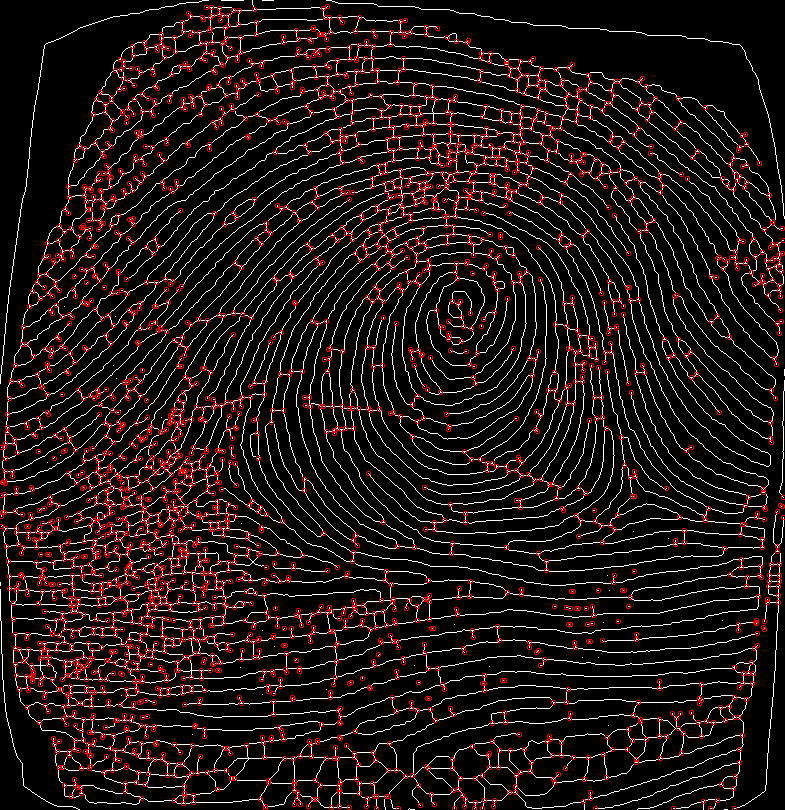

In [ ]:
# Show the results
Minutiae_image_1 = ShowResults1(skel, TermLabel, BifLabel)
Minutiae_image_1

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
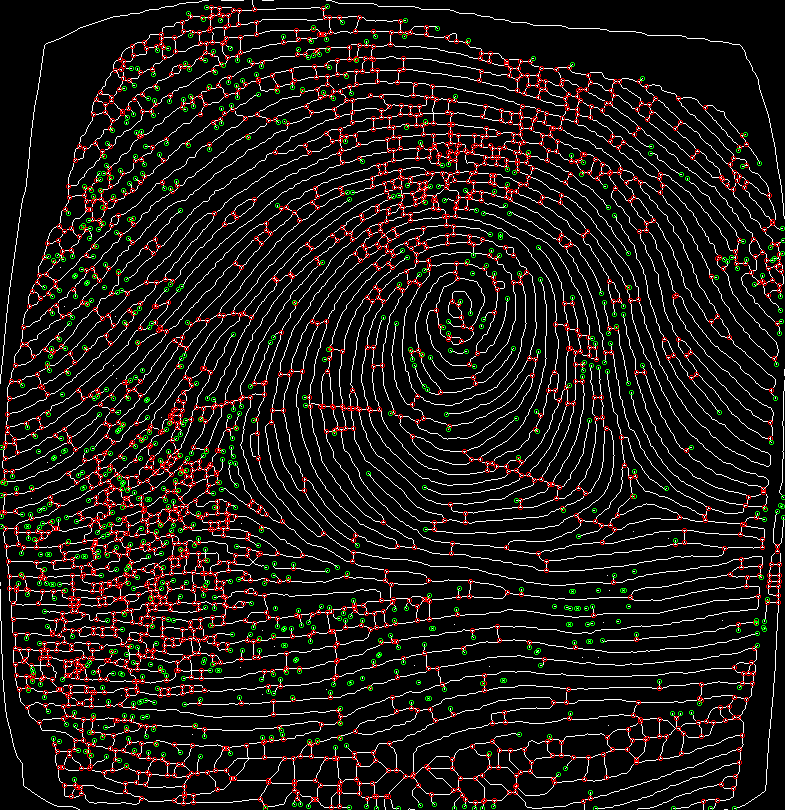

In [ ]:
Minutiae_image_2 = ShowResults2(skel, TermLabel, BifLabel)
Minutiae_image_2

# Persistence Barcode

## Barcode Generation

In [ ]:
def enhance_image(image):
    return cv2.equalizeHist(image)

def binarize_image(image):
    _, binary_img = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary_img

def thin_image(binary_image):
    return skeletonize(binary_image // 255)

def extract_minutiae(skeleton_image):
    inverted_skeleton = invert(skeleton_image)
    corners = corner_peaks(corner_harris(inverted_skeleton), min_distance=1)
    return corners

def reduce_minutiae_points(points, max_points=100):
    if len(points) > max_points:
        kmeans = KMeans(n_clusters=max_points, random_state=0).fit(points)
        reduced_points = kmeans.cluster_centers_
    else:
        reduced_points = points
    return reduced_points

def compute_distance_matrix(points):
    return distance_matrix(points, points, p=2)  # Euclidean distance (L2 norm)

def construct_vietoris_rips_filtration(dist_matrix, max_dimension=1, max_filtration_value=np.inf):
    rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_filtration_value)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    return simplex_tree

def compute_persistent_homology(simplex_tree):
    return simplex_tree.persistence()

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
    return images

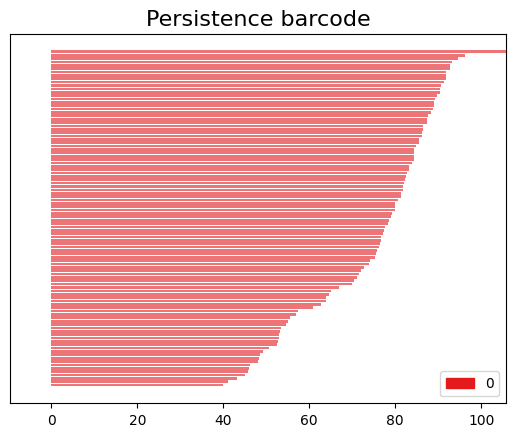

In [ ]:
def main(image):
    # Load and preprocess the fingerprint image
#    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    enhanced_img = enhance_image(image)
    binary_img = binarize_image(enhanced_img)
    skeleton_img = thin_image(binary_img)
    minutiae_points = extract_minutiae(skeleton_img)

    # Reduce the number of minutiae points
    reduced_minutiae_points = reduce_minutiae_points(minutiae_points, max_points=100)

    # Compute the distance matrix and construct the Vietoris-Rips filtration
    dist_matrix = compute_distance_matrix(reduced_minutiae_points)
    simplex_tree = construct_vietoris_rips_filtration(dist_matrix)

    # Compute the persistent homology and plot the barcode
    persistence = compute_persistent_homology(simplex_tree)
    gd.plot_persistence_barcode(persistence)
    plt.show()


#    image_path = '/content/fingerprint_609_10.png'
main(sketched)

## Distance Matrix

In [ ]:
def extract_minutiae_points_from_image(image):
    enhanced_img = enhance_image(image)
    binary_img = binarize_image(enhanced_img)
    skeleton_img = thin_image(binary_img)
    minutiae_points = extract_minutiae(skeleton_img)
    reduced_minutiae_points = reduce_minutiae_points(minutiae_points, max_points=100)
    return reduced_minutiae_points

def is_valid_barcode(barcode):
    return len(barcode) > 0 and np.isfinite(barcode).all()

def filter_inf_values(barcode):
    return barcode[np.isfinite(barcode).all(axis=1)]

def compute_distance_matrix_between_barcodes(barcodes):
    num_barcodes = len(barcodes)
    distance_matrix = np.zeros((num_barcodes, num_barcodes))
    for i, j in itertools.combinations(range(num_barcodes), 2):
        filtered_barcode_i = filter_inf_values(barcodes[i])
        filtered_barcode_j = filter_inf_values(barcodes[j])
        if not is_valid_barcode(filtered_barcode_i) or not is_valid_barcode(filtered_barcode_j):
            distance = np.inf  # Assign a large distance if any barcode is invalid
        else:
            distance = wasserstein_distance(filtered_barcode_i.flatten(), filtered_barcode_j.flatten())
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance
    return distance_matrix

In [ ]:
folder_path = '/content/drive/MyDrive/S4DS/Barcode_U/After_Barcode_U'  # Replace with your folder path
barcode_images = load_images_from_folder(folder_path)

# Ensure that the barcodes are lists of birth-death pairs
for i, barcode in enumerate(barcode_images):
    barcode_images[i] = np.array(barcode)

# Compute distance matrix between persistence barcodes
dist_matrix_barcodes = compute_distance_matrix_between_barcodes(barcode_images)

# Display the distance matrix using pandas
dist_matrix_df = pd.DataFrame(dist_matrix_barcodes)
print("Distance Matrix Between Persistence Barcodes:")
print(dist_matrix_df)

Distance Matrix Between Persistence Barcodes:
          0         1         2         3         4         5         6  \
0  0.000000  0.646737  2.675402  0.047331  2.699298  6.128637  0.645568   
1  0.646737  0.000000  3.276209  0.646612  2.098664  5.528003  1.292304   
2  2.675402  3.276209  0.000000  2.629597  5.374700  8.804039  2.037622   
3  0.047331  0.646612  2.629597  0.000000  2.745102  6.174442  0.676755   
4  2.699298  2.098664  5.374700  2.745102  0.000000  3.429339  3.337078   
5  6.128637  5.528003  8.804039  6.174442  3.429339  0.000000  6.766417   
6  0.645568  1.292304  2.037622  0.676755  3.337078  6.766417  0.000000   
7  5.109629  4.508995  7.785030  5.155433  2.410331  1.019009  5.747408   
8  6.445911  5.845277  9.121313  6.491715  3.746613  0.399387  7.083691   
9  0.883360  1.484168  1.792042  0.837555  3.582658  7.011997  0.245580   

          7         8         9  
0  5.109629  6.445911  0.883360  
1  4.508995  5.845277  1.484168  
2  7.785030  9.121313  1.7

In [ ]:
import pandas as pd

# Convert the distance matrix to a pandas DataFrame
dist_matrix_df = pd.DataFrame(dist_matrix_barcodes)

# Display the DataFrame
print("Distance Matrix Between Persistence Barcodes:")
dist_matrix_df

Distance Matrix Between Persistence Barcodes:


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.646737,2.675402,0.047331,2.699298,6.128637,0.645568,5.109629,6.445911,0.883360
1,0.646737,0.000000,3.276209,0.646612,2.098664,5.528003,1.292304,4.508995,5.845277,1.484168
2,2.675402,3.276209,0.000000,2.629597,5.374700,8.804039,2.037622,7.785030,9.121313,1.792042
3,0.047331,0.646612,2.629597,0.000000,2.745102,6.174442,0.676755,5.155433,6.491715,0.837555
4,2.699298,2.098664,5.374700,2.745102,0.000000,3.429339,3.337078,2.410331,3.746613,3.582658
5,6.128637,5.528003,8.804039,6.174442,3.429339,0.000000,6.766417,1.019009,0.399387,7.011997
6,0.645568,1.292304,2.037622,0.676755,3.337078,6.766417,0.000000,5.747408,7.083691,0.245580
7,5.109629,4.508995,7.785030,5.155433,2.410331,1.019009,5.747408,0.000000,1.336282,5.992988
8,6.445911,5.845277,9.121313,6.491715,3.746613,0.399387,7.083691,1.336282,0.000000,7.329271
9,0.883360,1.484168,1.792042,0.837555,3.582658,7.011997,0.245580,5.992988,7.329271,0.000000


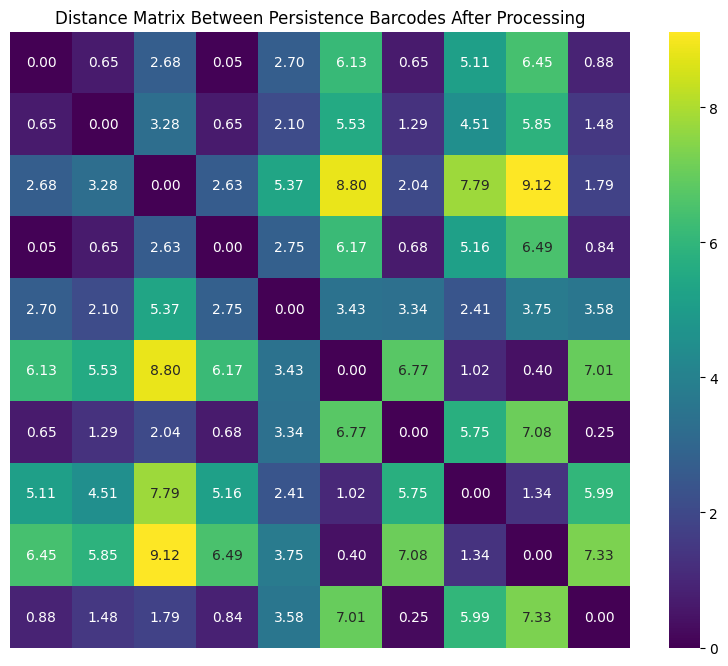

In [ ]:
# Create a heatmap to visualize the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix_barcodes, annot=True, fmt=".2f", cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("Distance Matrix Between Persistence Barcodes After Processing")
plt.show()

In [ ]:
# Normalize the distance matrix to range [0, 1]
max_val = np.nanmax(dist_matrix_barcodes[np.isfinite(dist_matrix_barcodes)])
min_val = np.nanmin(dist_matrix_barcodes[np.isfinite(dist_matrix_barcodes)])
norm_dist_matrix_barcodes = (dist_matrix_barcodes - min_val) / (max_val - min_val)

# Convert the distance matrix to a pandas DataFrame
dist_matrix_df = pd.DataFrame(norm_dist_matrix_barcodes)

# Display the DataFrame
print("Distance Matrix Between Persistence Barcodes:")
print(dist_matrix_df)



Distance Matrix Between Persistence Barcodes:
          0         1         2         3         4         5         6  \
0  0.000000  0.657031  0.803532  0.026924  0.162714  0.392779  0.768749   
1  0.657031  0.000000  0.146501  0.630108  0.494336  0.264253  0.111717   
2  0.803532  0.146501  0.000000  0.776609  0.640837  0.410754  0.043786   
3  0.026924  0.630108  0.776609  0.000000  0.141680  0.365855  0.741825   
4  0.162714  0.494336  0.640837  0.141680  0.000000  0.230084  0.606053   
5  0.392779  0.264253  0.410754  0.365855  0.230084  0.000000  0.375970   
6  0.768749  0.111717  0.043786  0.741825  0.606053  0.375970  0.000000   
7  0.096846  0.560186  0.706687  0.070776  0.070904  0.295933  0.671903   
8  0.196468  0.853499  1.000000  0.223391  0.359182  0.589246  0.965216   
9  0.091824  0.565207  0.711708  0.074195  0.070890  0.300955  0.676925   

          7         8         9  
0  0.096846  0.196468  0.091824  
1  0.560186  0.853499  0.565207  
2  0.706687  1.000000  0.7

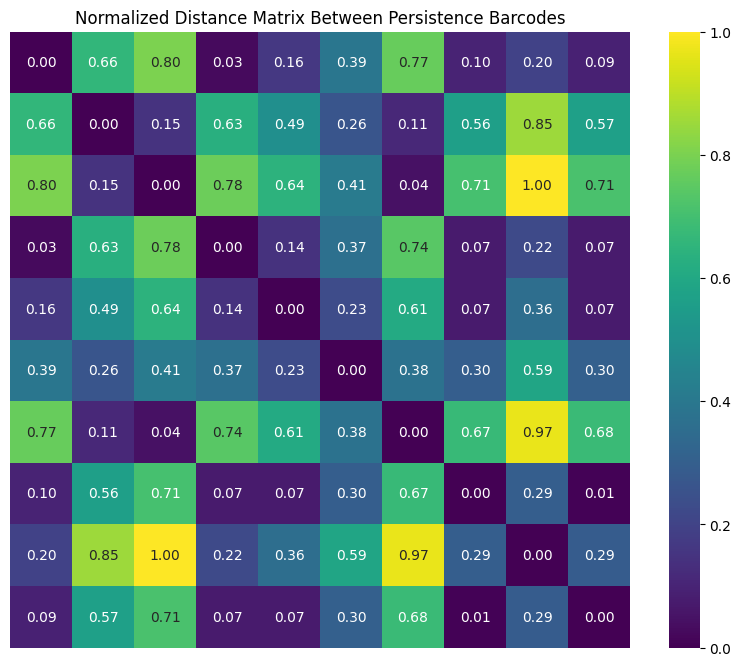

In [ ]:
# Create a heatmap to visualize the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(norm_dist_matrix_barcodes, annot=True, fmt=".2f", cmap="viridis", xticklabels=False, yticklabels=False, vmin=0, vmax=1)
plt.title("Normalized Distance Matrix Between Persistence Barcodes")
plt.show()

## Barcode Generation

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


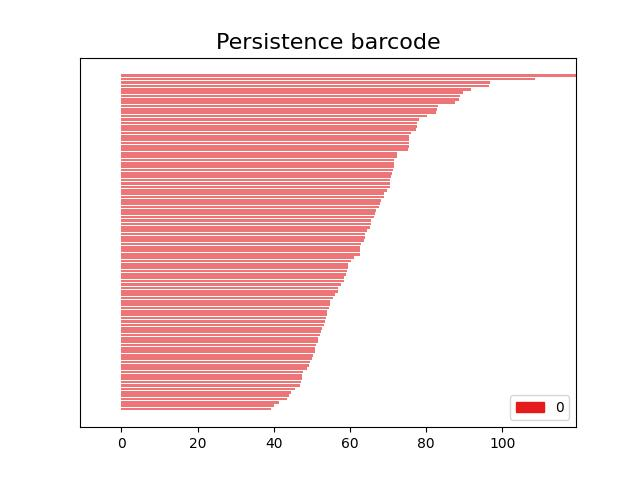

In [ ]:
import os
import cv2
import numpy as np
import itertools
import skimage
from scipy.stats import wasserstein_distance
from skimage.feature import corner_harris, corner_peaks
from skimage.morphology import skeletonize, convex_hull_image, erosion, square
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import gudhi as gd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from io import BytesIO
from skimage import feature, morphology




plt.rcParams['text.usetex'] = False
# Function to detect ridges using Hessian matrix
def detect_ridges(gray, sigma=0.1):
    H_elems = skimage.feature.hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = skimage.feature.hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

# Function to get termination and bifurcation points
def getTerminationBifurcation(img, mask):
    img = img == 255
    (rows, cols) = img.shape
    minutiaeTerm = np.zeros(img.shape)
    minutiaeBif = np.zeros(img.shape)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if img[i][j] == 1:
                block = img[i - 1:i + 2, j - 1:j + 2]
                block_val = np.sum(block)
                if block_val == 2:
                    minutiaeTerm[i, j] = 1
                elif block_val == 4:
                    minutiaeBif[i, j] = 1

    mask = skimage.morphology.convex_hull_image(mask > 0)
    mask = skimage.morphology.erosion(mask, skimage.morphology.square(5))
    minutiaeTerm = np.uint8(mask) * minutiaeTerm
    return minutiaeTerm, minutiaeBif


class MinutiaeFeature:
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block)
    CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
    if minutiaeType.lower() == 'termination':
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if (i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0:
                    angle = -np.degrees(np.arctan2(i - CenterY, j - CenterX))
                    sumVal += 1
                    if sumVal > 1:
                        angle = float('nan')
        return angle
    elif minutiaeType.lower() == 'bifurcation':
        angle = []
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if (i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0:
                    angle.append(-np.degrees(np.arctan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if sumVal != 3:
            angle = float('nan')
        return angle


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []
    minutiaeTerm = label(minutiaeTerm, connectivity=2)
    RP = regionprops(minutiaeTerm)
    WindowSize = 2
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = label(minutiaeBif, connectivity=2)
    RP = regionprops(minutiaeBif)
    WindowSize = 1
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return FeaturesTerm, FeaturesBif

def AddMinutiae(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0
    minutiaeTerm = BifLabel * 0

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel
    DispImg[:, :, 1] = skel
    DispImg[:, :, 2] = skel

    # Assuming you have already obtained FeaturesTerm and FeaturesBif
    minutiae_points = []
    for feature in FeaturesTerm + FeaturesBif:
        minutiae_points.append([feature.locX, feature.locY])
    return minutiae_points


# Path to the fingerprint image
img_path = '/content/609_1.png'

# Load the image
img = cv2.imread(img_path, 0)
if img is None:
    raise ValueError(f"Image didn't load. Check that '{img_path}' exists.")

# Apply Otsu's thresholding
ret, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Skeletonize the binary image
skel = skeletonize(img_bin // 255)
skel = np.uint8(skel) * 255

# Create a mask from the binary image
mask = img_bin * 255

# Get termination and bifurcation points
minutiaeTerm, minutiaeBif = getTerminationBifurcation(skel, mask)
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)


def reduce_minutiae_points(points, max_points=100):
    if len(points) > max_points:
        kmeans = KMeans(n_clusters=max_points, random_state=0).fit(points)
        reduced_points = kmeans.cluster_centers_
    else:
        reduced_points = points
    return reduced_points

def compute_distance_matrix(points):
    return distance_matrix(points, points)  # Euclidean distance (L2 norm)

def construct_vietoris_rips_filtration(dist_matrix, max_dimension=1, max_filtration_value=np.inf):
    rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_filtration_value)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    return simplex_tree

def compute_persistent_homology(simplex_tree):
    return simplex_tree.persistence()

# Label the features for visualization
BifLabel = label(minutiaeBif, connectivity=1)
TermLabel = label(minutiaeTerm, connectivity=1)
minutiae_points = AddMinutiae(skel, TermLabel, BifLabel)
# Reduce the number of minutiae points
reduced_minutiae_points = reduce_minutiae_points(minutiae_points, max_points=100)

# Compute the distance matrix and construct the Vietoris-Rips filtration
dist_matrix = compute_distance_matrix(reduced_minutiae_points)
simplex_tree = construct_vietoris_rips_filtration(dist_matrix)

# Compute the persistent homology and plot the barcode
persistence = compute_persistent_homology(simplex_tree)
# Save the plot to a BytesIO object
img_stream = BytesIO()

# Plot the persistence barcode
gd.plot_persistence_barcode(persistence)
plt.savefig(img_stream, format='jpg')  # Save the figure to the BytesIO object
plt.close()  # Close the figure to avoid display

# Reset the stream position to the beginning
img_stream.seek(0)

# Now you can use img_stream as needed, e.g., convert to PIL Image, or base64
from PIL import Image
img = Image.open(img_stream)
img